In [1]:
import torch
from torch.utils.data import Dataset
import os

#### Define the Dataset for Multi-digit-MNIST Images ####
<br>
We have to generate data in a train and test set. <br>
This can be done by the functions in "makeMultiDigits.ipynb" <br>
<br>
Or can we split data into train and test? <br>
Not sure, because we have (muliti-digit image, label, merge-coordinates) as "data-label" tripletts, not pairs. <br>
Of course (img, (lab, mc)) would be feasible.

In [3]:
class MultiDigitMNISTDataset(Dataset):
    def __init__(self, source_dir, img_transform=None, label_transform=None, merge_point_transform=None):
        self.source_dir = source_dir
        self.img_transform = img_transform
        self.label_transform = label_transform
        self.merge_point_transform = merge_point_transform
        
        self.data_record_entries = []
        cwd = os.getcwd()
        self.source_path = os.path.join(cwd, self.source_dir)
        with os.scandir(self.source_path) as it:
            for entry in it:
                if entry.is_file() and entry.name.endswith(".pt"):
                    self.data_record_entries.append(entry)
        
        self.data_records = []
    
    def __len__(self):
        return len(self.data_record_entries)
    
    def __getitem__(self, idx):
        data_record = torch.load(os.path.join(self.source_path, self.data_record_entries[idx].name))
        multi_img = data_record["multi_img"]
        multi_img_label = data_record["multi_img_label"]
        merge_points = data_record["merge_points"]
        if self.img_transform:
            multi_img = self.img_transform(multi_img)
        if self.label_transform:
            multi_img_label = self.label_transform(multi_img_label) 
        if self.merge_point_transform:
            merge_points = self.merge_point_transform(merge_points)
        
        return multi_img, multi_img_label, merge_points




### Build the Neural Net to learn finding the merge-points ###
<br>
At first we presume, that we know the number of merge-points and ask only for their x-coordinate
<br>
These coordinates will be used to split the image of the multi-digit number into single-digit numbers, <br>
leaving us with an standard MNIST-like problem for which there are good solutions available.


In [64]:
import torch.nn.functional as F

class MultiDigitMNISTNet(torch.nn.Module):

    def __init__(self, nof_digits):
        super(MultiDigitMNISTNet, self).__init__()
        # input MNIST images for nof_digits digit-image: 1 x nof_digitsx28 x nof_digitsx28
        self.numChannels1 = 8
        self.numChannels2 = 32
        self.conv1 = torch.nn.Conv2d(1, self.numChannels1, 5, padding=2, bias=False) # <- out: 8 x (nof_digits x 28) x 28  # <- max-pooling out: 8 x (nof_digits x 14) x 14
        self.conv1_batchnorm = torch.nn.BatchNorm2d(num_features = self.numChannels1)
        
        # use normal initialization for conv1:
        torch.nn.init.normal_(self.conv1.weight)
        torch.nn.init.constant_(self.conv1_batchnorm.weight, 0.5)
        torch.nn.init.zeros_(self.conv1_batchnorm.bias)
        
        self.conv2 = torch.nn.Conv2d(self.numChannels1, self.numChannels2, 3, padding=1, bias=False) #<- out: 16 x (nof_digits x 14) x 14
        self.conv2_batchnorm = torch.nn.BatchNorm2d(num_features = self.numChannels2)

         # use normal initialization for conv2:
        torch.nn.init.normal_(self.conv2.weight)
        torch.nn.init.constant_(self.conv2_batchnorm.weight, 0.5)
        torch.nn.init.zeros_(self.conv2_batchnorm.bias)

        self.fc1 = torch.nn.Linear(self.numChannels2 * (nof_digits * 7) * 7, 256)
        self.fc2 = torch.nn.Linear(256, nof_digits)
    
    def forward(self, x):
        x = self.conv1_batchnorm(self.conv1(x))
        x = F.max_pool2d(F.relu(x), (2,2))
        x = self.conv2_batchnorm(self.conv2(x))
        x = F.max_pool2d(F.relu(x), (2,2))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [66]:
# check of network: does it produce any output without Python error?

pseudo_img = torch.rand(2, 1, 28, 112)
print(pseudo_img.shape)

model = MultiDigitMNISTNet(nof_digits = 4)

# model output on random input-tensor:
print(f"Model-Output: {model(pseudo_img)}")

# have a look at the initialization:
print(f"model.conv1 : {model.conv1.weight[0][0]}")

torch.Size([2, 1, 28, 112])
Model-Output: tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0243, 0.0000]], grad_fn=<ReluBackward0>)
model.conv1 : tensor([[-1.0125, -0.7907,  0.6885, -0.1336, -0.5446],
        [-0.8013, -0.6730,  1.4326, -1.4076,  1.6180],
        [-0.9377, -1.8944,  0.4382, -0.1660,  1.1149],
        [ 0.9537, -0.8434, -0.0946, -1.8602, -1.2214],
        [-0.5398, -0.2956,  0.1690,  0.5774,  0.8660]],
       grad_fn=<SelectBackward0>)


In [54]:
import datetime

def training(epochs, train_loader, model, loss_fn, optimizer, device, show_progress= False, L2_regularization=False, L1_regularization=False, L2_lambda=0.001, L1_lambda=0.001):
    l2_norm = 0
    l1_norm = 0
    model.train()
    for epoch in range(1, epochs + 1):
        loss_train = 0.0
        for imgs, labs, mpoints in train_loader:
            imgs = imgs.to(device)
            mpoints = mpoints.to(device)
            
            y_mpoints = model(imgs)
            loss = loss_fn(y_mpoints, mpoints)
            
            if(L2_regularization):
                l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
                loss = loss + L2_lambda * l2_norm
            
            if(L1_regularization):
                l1_norm = sum(p.abs().sum() for p in model.parameters())
                loss = loss + L1_lambda * l1_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if(epoch == 1 or epoch%10 == 0):
            print(F"len train loader: {len(train_loader)}")
            print(f"{datetime.datetime.now()} Epoch {epoch} Training loss {loss_train/ len(train_loader)}")
            if(show_progress): # prints out some weights to see if anything happens at all:
                print(model.conv1.weight[0][0:10])


def validate(model, train_loader, val_loader, loss_fn):
    model.eval()
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        loss = 0
        for imgs, _ , mpoints in loader:
            with torch.no_grad():
                y_mpoints = model(imgs)
                loss += loss_fn(y_mpoints, mpoints).item()
        
        print(f"Loss {name}: {loss/len(loader)}")



In [67]:
from torch.utils.data import DataLoader

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device {device}")

BATCH_SIZE = 32
NOF_DIGITS = 2
TRAIN_DIR = "Mnist2_train"
VAL_DIR = "Mnist2_val"

TRAIN_DS = MultiDigitMNISTDataset(source_dir=TRAIN_DIR)
TRAIN_DL = DataLoader(TRAIN_DS, batch_size=BATCH_SIZE)

VAL_DS = MultiDigitMNISTDataset(source_dir=VAL_DIR)
VAL_DL = DataLoader(VAL_DS, batch_size=BATCH_SIZE)

# start with a new model each time:
model = None
model = MultiDigitMNISTNet(nof_digits= NOF_DIGITS).to(device=device)

# using weight_decay in SGD optimizer invoces L2 regularization
#  - seems to be necessary since our wheigths and losses are extraordingly high with SGD- optimizer:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-5) # this optimizer is divergent most of the time leading to nan-size loss!

optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()

training(
    epochs = 30,
    train_loader = TRAIN_DL,
    model = model,
    loss_fn = loss_fn,
    optimizer = optimizer,
    device = device,
    show_progress = False,
    L2_regularization = True,
    L1_regularization = True,
    L1_lambda=0.01    
)

print("Training finished")


Using device cpu
len train loader: 29
2022-01-20 20:58:38.257901 Epoch 1 Training loss 329.94758658573545
len train loader: 29
2022-01-20 20:59:03.308582 Epoch 10 Training loss 46.07372139240133
len train loader: 29
2022-01-20 20:59:30.844762 Epoch 20 Training loss 36.33212898517477
len train loader: 29
2022-01-20 20:59:58.693238 Epoch 30 Training loss 30.7021242996742
Training finished


In [68]:
validate(
    model = model,
    train_loader = TRAIN_DL,
    val_loader = VAL_DL, 
    loss_fn = loss_fn
)

print("Validation finished.")

Loss train: 5.196927629668137
Loss val: 7.262643541608538
Validation finished.


In [69]:
# check the points, where the images are merged ("merge_points"), by drawing a grey vertical line:

from PIL import ImageDraw
import torchvision.transforms as TT
import matplotlib.pyplot as plt
import numpy as np

def display_merge_lines(image_record, model):
    t_img = image_record["multi_img"]
    y_mps = model(t_img.unsqueeze(0)).detach().numpy() # unsqueeze to make it a batch
    img = TT.ToPILImage()(t_img)
    plt.title(mr["multi_img_label"])
    merge_points = mr["merge_points"]
    
    draw = ImageDraw.Draw(img)
    for ymp in [mp for mp in np.nditer(y_mps)]:
        draw.line([(ymp, 0), (ymp, 28)], width=1, fill= 128)
    plt.imshow(img, cmap="gray")

t_img.shape: torch.Size([1, 28, 56])


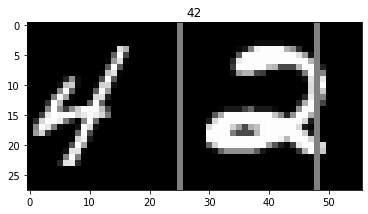

In [70]:
mr = torch.load("test2/42_26_51.pt")
#print(ir)
t_img = mr["multi_img"]
print(f"t_img.shape: {t_img.shape}")

display_merge_lines(mr, model)

In [28]:
mr = torch.load("test2/42_26_51.pt")
print(mr)


{'multi_img': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'multi_img_label': '42', 'merge_points': tensor([26., 51.])}
